In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from help_functions import *    
from scipy import stats
from scipy.stats import norm, skew

# read google drive csv link
url='https://drive.google.com/file/d/1pTAXAbKougBRNgaFSu6RzILe7vONfmzZ/view?usp=drive_link'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url)
df.sample(10)

GameID  LeagueIndex Age HoursPerWeek TotalHours       APM  \
1499    4312            3  20           10        400   86.0328   
1693    4862            4  22            4        100   88.7010   
3056    8487            4  17            8        500  129.4314   
1001    2912            4  28            8        600   63.6066   
3223    8976            4  22           10        200   90.4866   
187      590            1  19           16        730   60.4956   
2815    7851            5  21           10        430  122.2194   
3029    8417            1  22           28        900   70.5282   
1339    3860            5  22           12        600  166.0650   
3003    8349            6  24           20       1000  184.2468   

      SelectByHotkeys  AssignToHotkeys  UniqueHotkeys  MinimapAttacks  \
1499         0.001605         0.000591              1        0.000032   
1693         0.001935         0.000488              3        0.000016   
3056         0.001585         0.000195              4        0.000195   
1001         0.001207         0.000445              2        0.000273   
3223         0.001919         0.000234              6        0.000027   
187          0.000831         0.000082              2        0.000000   
2815         0.002326         0.000555              6        0.000096   
3029         0.000368         0.000059              1        0.000000   
1339         0.005434         0.000420              4        0.000073   
3003         0.006961         0.000616              8        0.001070   

      MinimapRightClicks  NumberOfPACs  GapBetweenPACs  ActionLatency  \
1499            0.000072      0.002571         45.1589        88.7205   
1693            0.000341      0.003285         30.1294        60.4158   
3056            0.000445      0.004269         33.0458        49.8502   
1001            0.000747      0.002500         47.3064        86.9195   
3223            0.000198      0.003162         30.9257        65.6068   
187             0.000615      0.002195        103.9624        93.3271   
2815            0.000843      0.004086         22.2723        50.5274   
3029            0.000036      0.003779         49.5268        59.3459   
1339            0.000504      0.005717         26.0956        34.9505   
3003            0.001678      0.003990         29.2129        47.7940   

      ActionsInPAC  TotalMapExplored  WorkersMade  UniqueUnitsMade  \
1499        5.8012                23     0.000303                4   
1693        4.6436                20     0.000911                6   
3056        5.2378                19     0.000876                4   
1001        4.5115                16     0.000862                7   
3223        4.7664                24     0.001189                7   
187         5.2103                36     0.001292                7   
2815        5.0914                20     0.000885                6   
3029        3.4780                44     0.001046                5   
1339        4.2679                24     0.001553                6   
3003        7.5150                47     0.001473                9   

      ComplexUnitsMade  ComplexAbilitiesUsed  
1499          0.000000              0.000000  
1693          0.000000              0.000228  
3056          0.000000              0.000000  
1001          0.000000              0.000172  
3223          0.000000              0.000000  
187           0.000318              0.000462  
2815          0.000000              0.000096  
3029          0.000000              0.000012  
1339          0.000000              0.000000  
3003          0.000325              0.000317

## Data Preprocessing & EDA

Finding of correlations
1. `SelectByHotkeys` and `NumberOfPACs` positively correlates with `APM`.
2. `ActionLatency` and `GapBetwwenPACs` showed some correlation with `APM`.

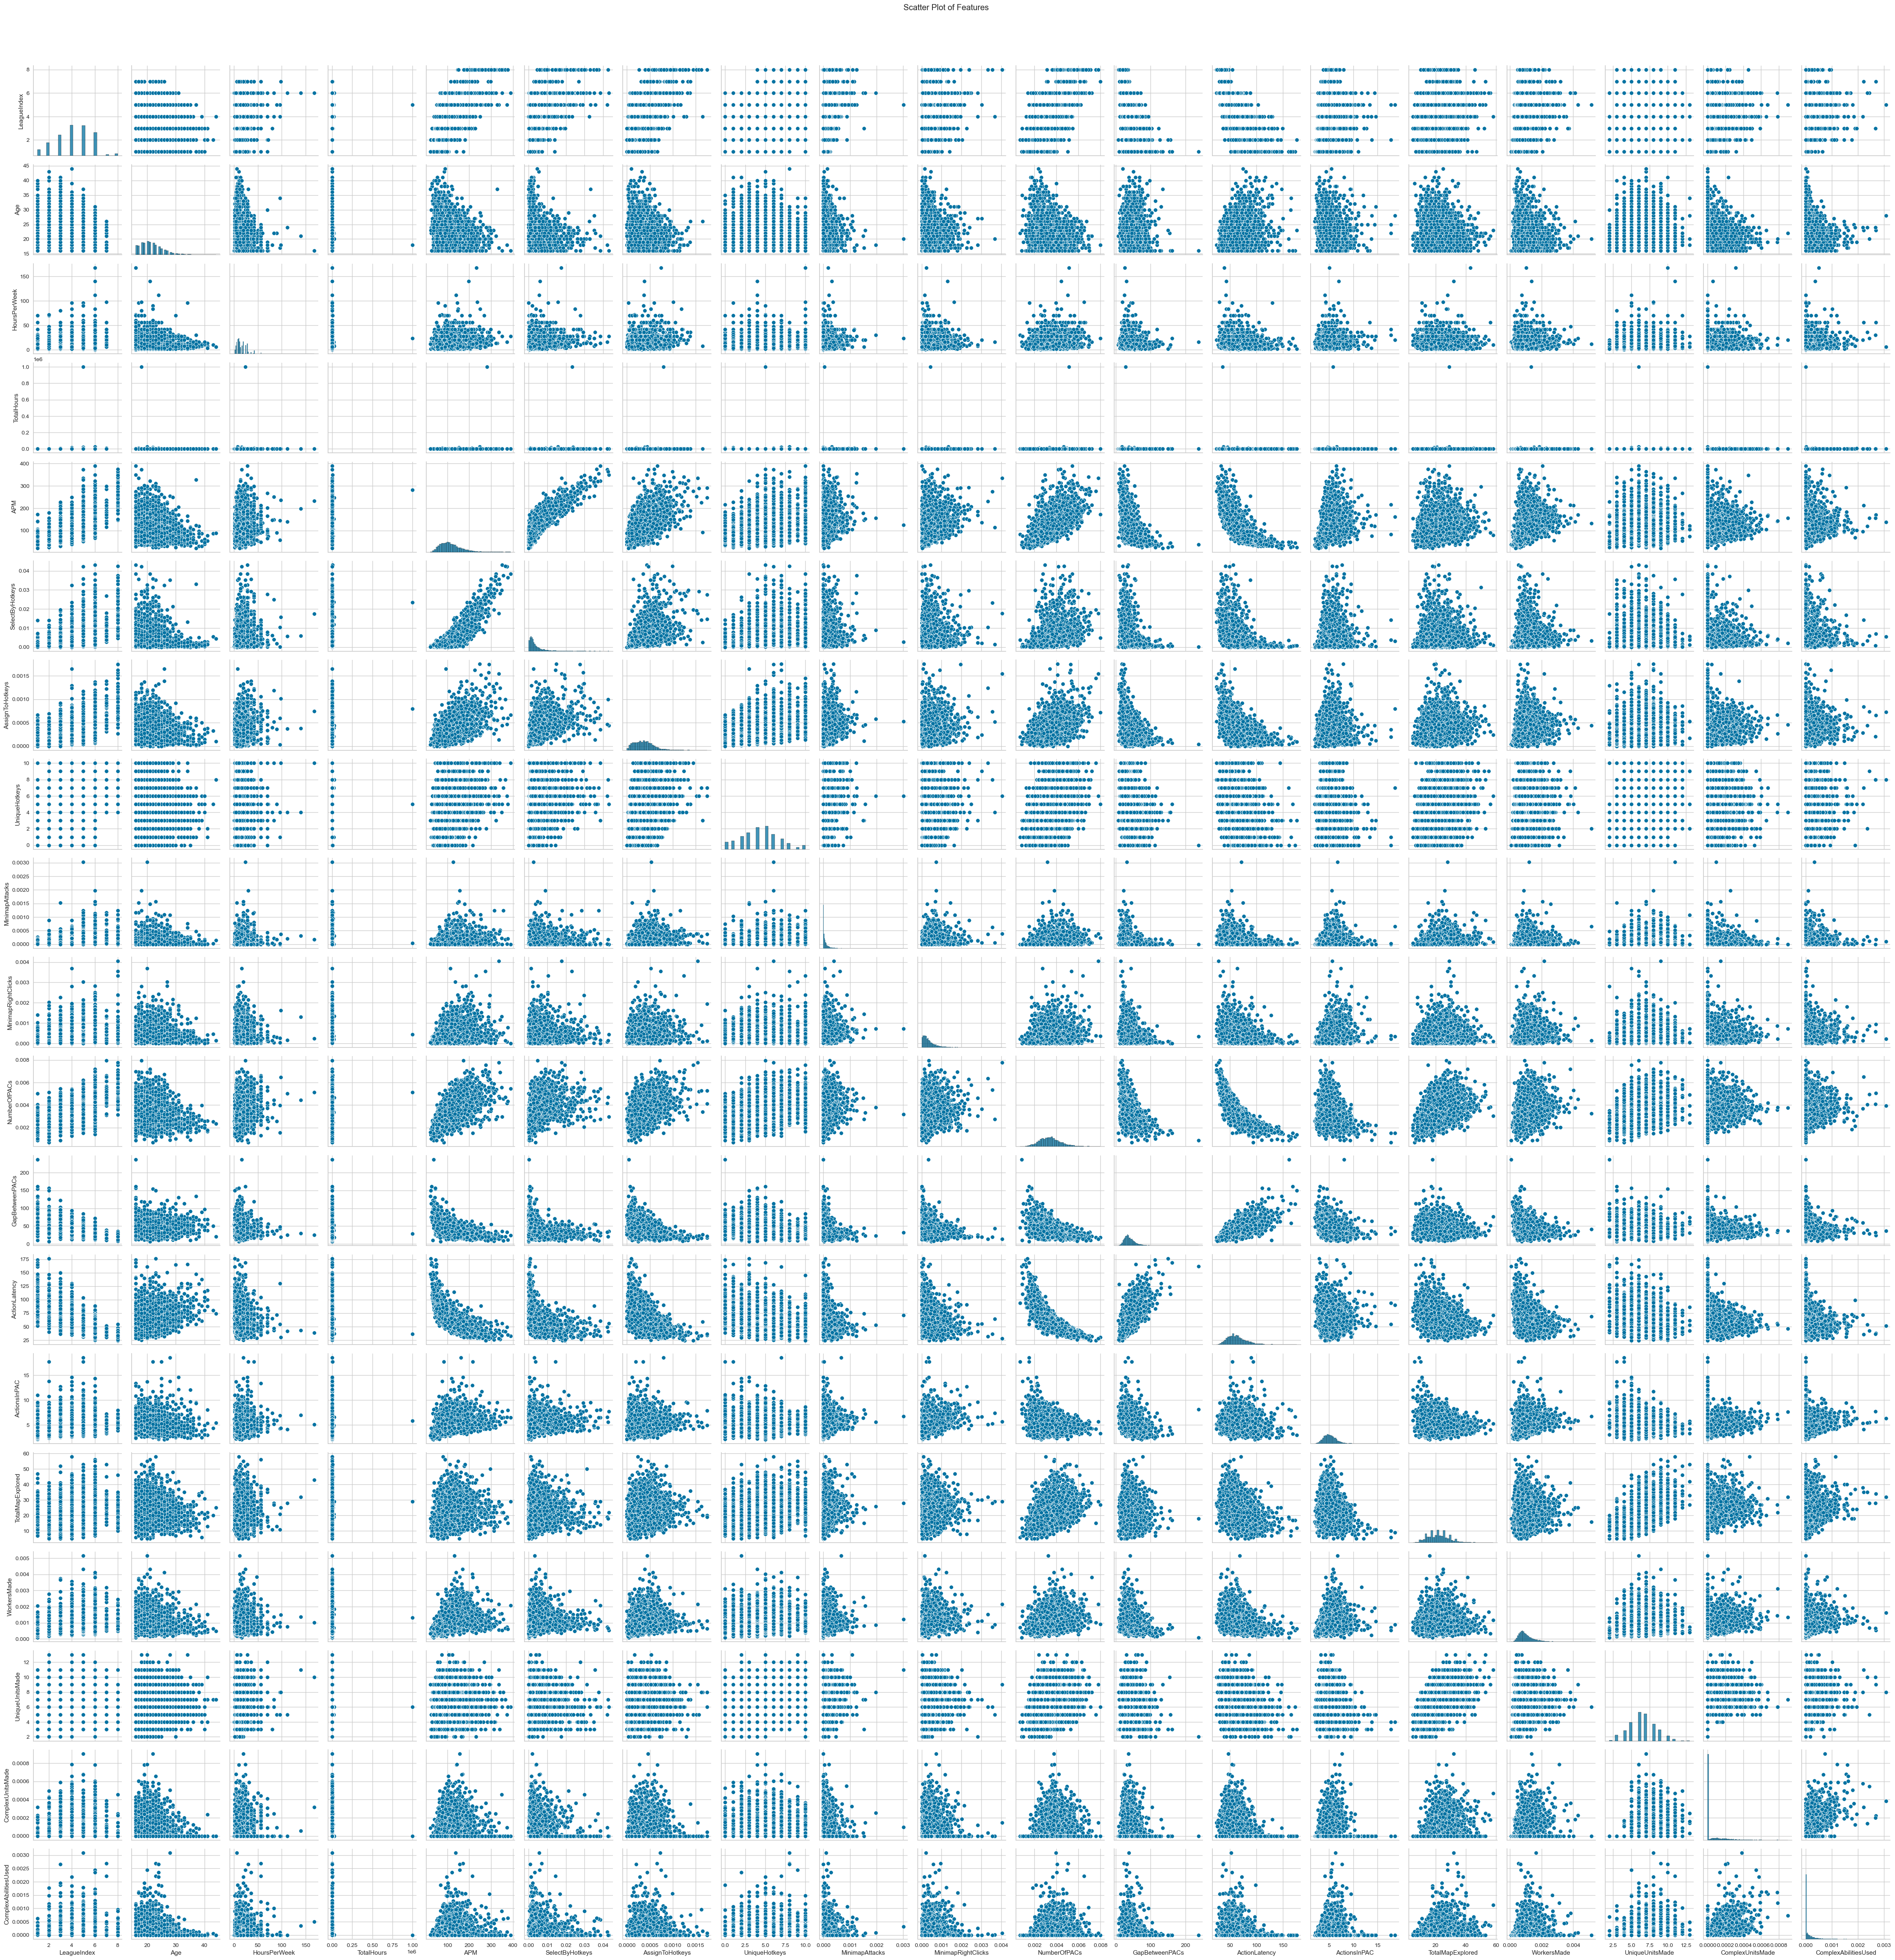

In [170]:
plot_df = df.drop([358, 1841], axis=0).drop(['GameID'], axis=1)
plot_df = plot_df.replace('?', np.nan)

plot_df['HoursPerWeek'] = pd.to_numeric(plot_df['HoursPerWeek'], errors='coerce')
plot_df['TotalHours'] = pd.to_numeric(plot_df['TotalHours'], errors='coerce')
plot_df['Age'] = pd.to_numeric(plot_df['Age'], errors='coerce')

# create the scatter plot between all the features with the 3 features listed below
features = plot_df.columns.tolist()
sns.pairplot(data=plot_df[features])
plt.suptitle('Scatter Plot of Features', y=1.02)
plt.show()

Let's take a look at our target's data distribution. After doubling the data of GrandMaster, the distribution did not change much but now follows a normal distribution more closely.


 mu = 4.21, sigma = 1.54



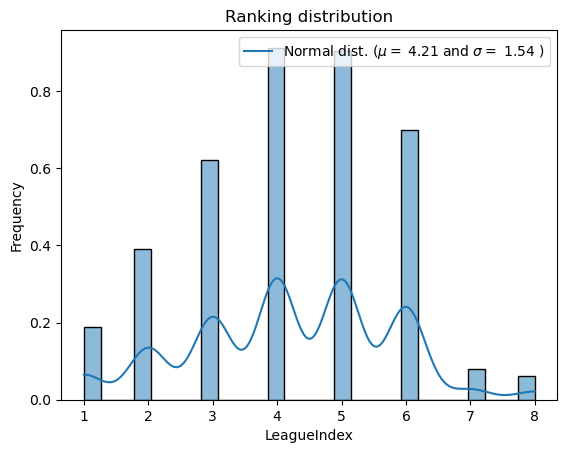

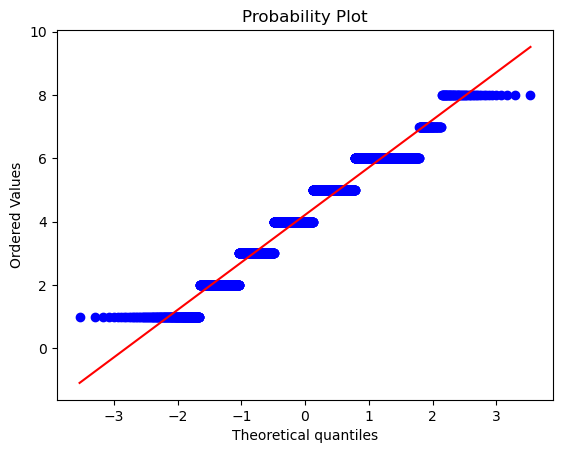

In [43]:
level7 = plot_df.loc[plot_df['LeagueIndex'] == 7]
ag1 = pd.concat([plot_df, level7], axis=0)
ag2 = pd.concat([ag1, level7], axis=0)

sns.histplot(ag1['LeagueIndex'], kde=True, stat='density')

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(ag1['LeagueIndex'])
print( '\n mu = {:.2f}, sigma = {:.2f}\n'.format(mu, sigma))

# Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Ranking distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(ag1['LeagueIndex'], plot=plt)
plt.show()

### Clustering
8 classes are not easy for models to learn, so I want to get some ideas by clustering to see if we can merge some minority classes. 

**Finding**: Based on the analysis below, I attempted to create a 5-class classification by grouping Level 1 and Level 2 into the first class, Level 3 into the second class, Level 4 into the third class, Level 5 into the fourth class, and the remaining levels into the last class. Unfortunately, this approach did not lead to an improvement in model performance, so I decided to remove this step. Nevertheless, the visualizations proved valuable in enhancing my understanding of the data, so I have retained them.

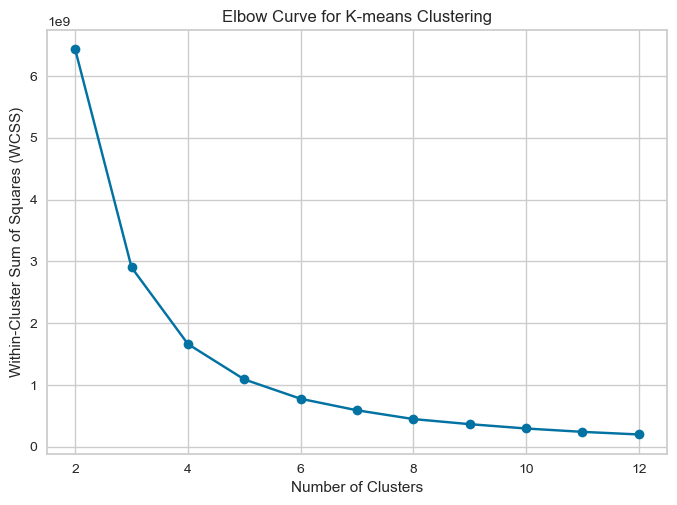

In [12]:
# Create features and target DataFrames
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

df0 = df.drop(['Age','HoursPerWeek','TotalHours'], axis=1)
df0 = df0.drop([1793], axis=0)

X = df0.drop(['LeagueIndex'], axis=1)
y = df0['LeagueIndex']

# Perform PCA
pca = PCA(n_components=2)
components = pca.fit_transform(X)

data_pca = pd.DataFrame(components, columns=['PC1', 'PC2'])
# Add back the LeagueIndex to the DataFrame
data_pca['LeagueIndex'] = df0['LeagueIndex']


# Perform K-means clustering with different numbers of clusters
inertia = []
num_clusters = range(2, 13)  # Testing for 2 to 12clusters

for k in num_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(components)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(num_clusters, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Curve for K-means Clustering')
plt.show()


/Users/yahan/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/yahan/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/yahan/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/var/folders/2w/50kgrt4947193cks8xv5p4nh0000gn/T/ipykernel_9649/3897010873.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be inc

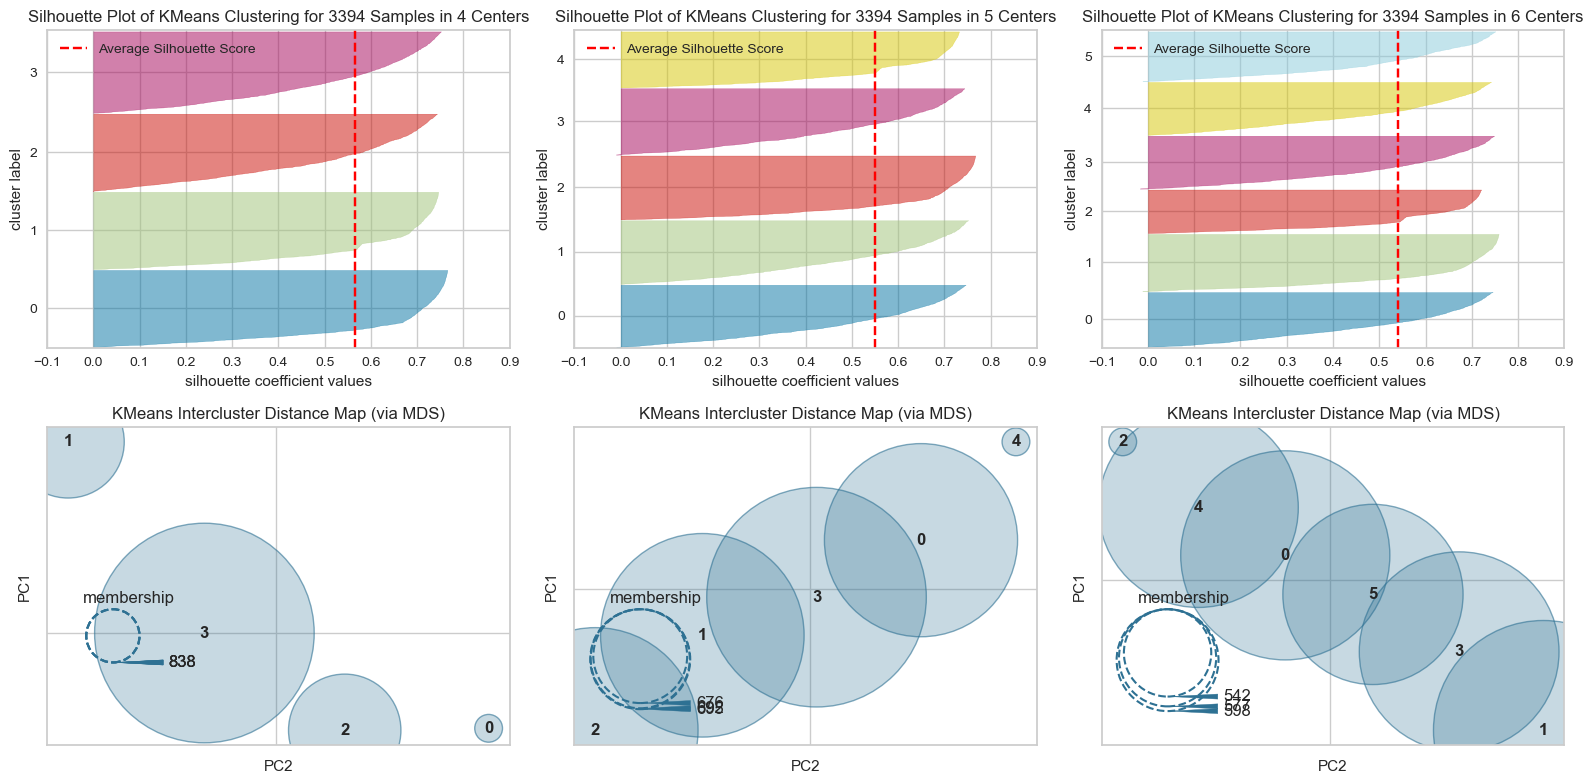

In [11]:
from yellowbrick.cluster import InterclusterDistance, SilhouetteVisualizer

fig, ax = plt.subplots(2, 3, figsize=(16, 8))

for i, k in enumerate(range(4, 7)):
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, random_state=42, n_init=10)

    # Fit the model
    model.fit(components)

    # Instantiate the SilhouetteVisualizer with the number of clusters and plot the figure
    visualizer1 = SilhouetteVisualizer(model, colors='yellowbrick', ax=ax[0,i])
    visualizer2 = InterclusterDistance(model, ax=ax[1,i])

    visualizer1.fit(components)  # Fit the data to the visualizer
    visualizer1.finalize()  # Finalize and render the figure
    visualizer2.fit(components)  # Fit the data to the visualizer
    visualizer2.finalize()  # Finalize and render the figure
    
plt.tight_layout()
plt.show()


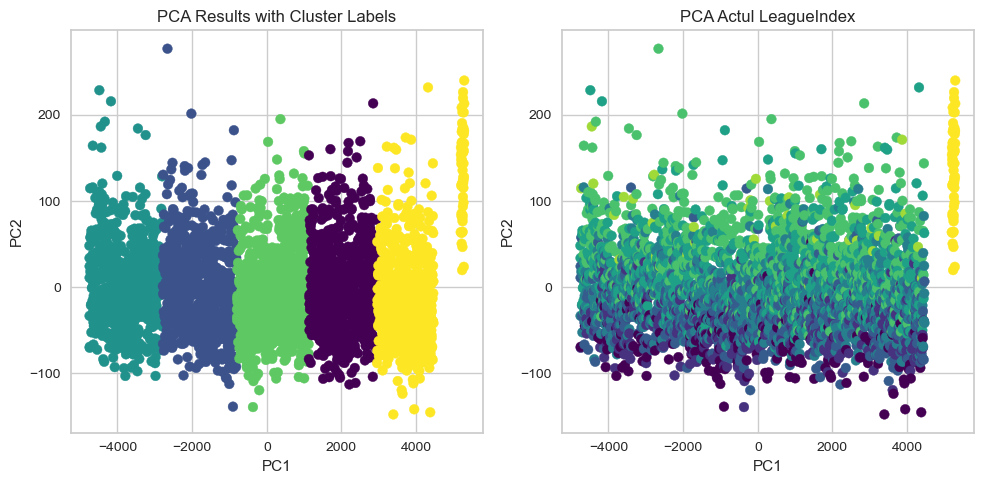

In [16]:
# keams with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans.fit(components)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# Add the cluster labels to the DataFrame
df0['cluster'] = kmeans.labels_

# Create a scatter plot of the first two principal components
ax[0].scatter(data_pca['PC1'], data_pca['PC2'], c=df0['cluster'], cmap='viridis')
ax[0].set_title("PCA Results with Cluster Labels")
ax[0].set_xlabel("PC1")
ax[0].set_ylabel("PC2")

# Create a scatter plot of the first two principal components - LeagueIndex
ax[1].scatter(data_pca['PC1'], data_pca['PC2'], c=df0['LeagueIndex'], cmap='viridis')
ax[1].set_title("PCA Actul LeagueIndex")
ax[1].set_xlabel("PC1")
ax[1].set_ylabel("PC2")

plt.tight_layout()
plt.show()


### missingness
- **Problem**: There is some missingness in the data, which indicates a Missing Not at Random (MNAR) pattern. This suggests that the missingness of data in these columns depends on the values of the data itself. 

- **Analysis**: We can impute the missing values using statistical or modeling methods, but there are potential pitfalls and biases, particularly when dealing with MNAR (Missing Not At Random) data. It is possible that the values are not applicable to professional players, or they may not contribute significantly to our prediction. The 'Age' of the professionals might be confidential in this dataset, while the 'HoursPerWeek' and 'TotalHours' for professionals could be fixed, similar to office hours. This could potentially cause data leakage in our prediction. Alternatively, we can utilize models like XGBoost or LightGBM, which can handle missing data directly. If we choose to use these models, we can replace all missing values in instances where 'LeagueIndex' == 8 with "-1", effectively treating the missingness as its own category. However, these boosting methods did not yield satisfactory performance.

- **Solution**: I have decided to fill the rows with missing values in both the `Age` and `HoursPerWeek` columns by using values calculated through a simple linear regression model. As for the `TotalHours` column, I have chosen to fill the missing values with the predicted median value obtained from linear regression based on the other classes. This decision is based on the skewed distribution of the data in this column, where using the result from Level 8 could potentially lead to extremely high values and introduce data leakage. By avoiding the utilization of information from other columns, I can prevent data leakage while retaining the maximum amount of data.

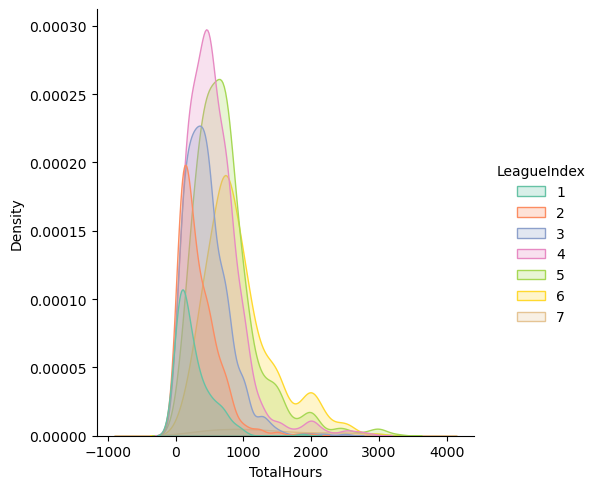

In [44]:
tmp_df = plot_df[plot_df['TotalHours'] < 3500]
# plot the density plot of TotalHours as a function of LeagueIndex
sns.displot(data=tmp_df, x='TotalHours', hue='LeagueIndex', kind='kde', fill=True, palette="Set2")
plt.show()

In [45]:
# if not all the values in 3 columns are ?, drop the rows
df[(df['Age'] == '?') | (df['HoursPerWeek'] == '?') | (df['TotalHours'] == '?')]
# drop the rows that have missingness but not in level 8
df = df.drop([358, 1841], axis=0)

# fill the "?" with liner regression result for each column
print('Age', get_filler(df, 'Age'))
print('HoursPerWeek', get_filler(df, 'HoursPerWeek'))

# calculate the mode of TotalHours for each LeagueIndex
data = pd.DataFrame(df.loc[df['TotalHours'] != '?'].groupby('LeagueIndex')['TotalHours'].apply(lambda x: x.median())).reset_index()
X = data[['LeagueIndex']]
y = data['TotalHours']
model = LinearRegression()
model.fit(X, y)
print('TotalHours', model.predict([[8]]))

# replace all the ? in age column with 21
df['Age'] = df['Age'].replace('?', 21).astype(int)
# replace all the ? in HoursPerWeek column with 23
df['HoursPerWeek'] = df['HoursPerWeek'].replace('?', 23).astype(int)
# replace all the ? in TotalHours column with 1236
df['TotalHours'] = df['TotalHours'].replace('?', 1236).astype(int)

Age [[20.21355266]]
HoursPerWeek [[22.89411719]]
TotalHours [1235.71428571]


/Users/yahan/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


### outliers
- **Findings**: 
1. Based on the pair plot, there are outliers in `HoursPerWeek` and `TotalHours`. Additionally, there are some outliers in `TotalHour`, `HoursPerWeek`, `MinimapAttack`, and `GapBetweenPACs`.
2. There are too many low end values in `MinimapAttacks`, `ComplexUnitsMade`, and `ComplexAbilitiesUsed`

- **Solution**: The strategy I used here is to remove the outliers that are extremely unreasonable and try to keep as many data points as possible. I applied the 3-sigma principle to aid in decision making. I removed 14 data points, the majority of which belong to the majority class. All prefessional's GameIDs are different from the others and we can tell that by raw eyes, so I deleted this column to prevent data leakage. 

In [46]:
df1 = df[df['TotalHours'] < three_sigma(df, 'TotalHours')]

# people who play more than 75 hours pe week (i.e. 11 hours per day) are considered outliers
df1.sort_values(by=['HoursPerWeek'], ascending=False).head(18)
df2 = df1[df1['HoursPerWeek']<75]

df3 = df2.drop([197, 1358, 474], axis=0)

clean_df = df2.drop(["GameID"], axis=1)
clean_df.shape, df.shape

((3382, 19), (3393, 20))

In [48]:
level7 = plot_df.loc[plot_df['LeagueIndex'] == 7]
clean_df = pd.concat([clean_df, level7], axis=0)

### More EDA after some processing

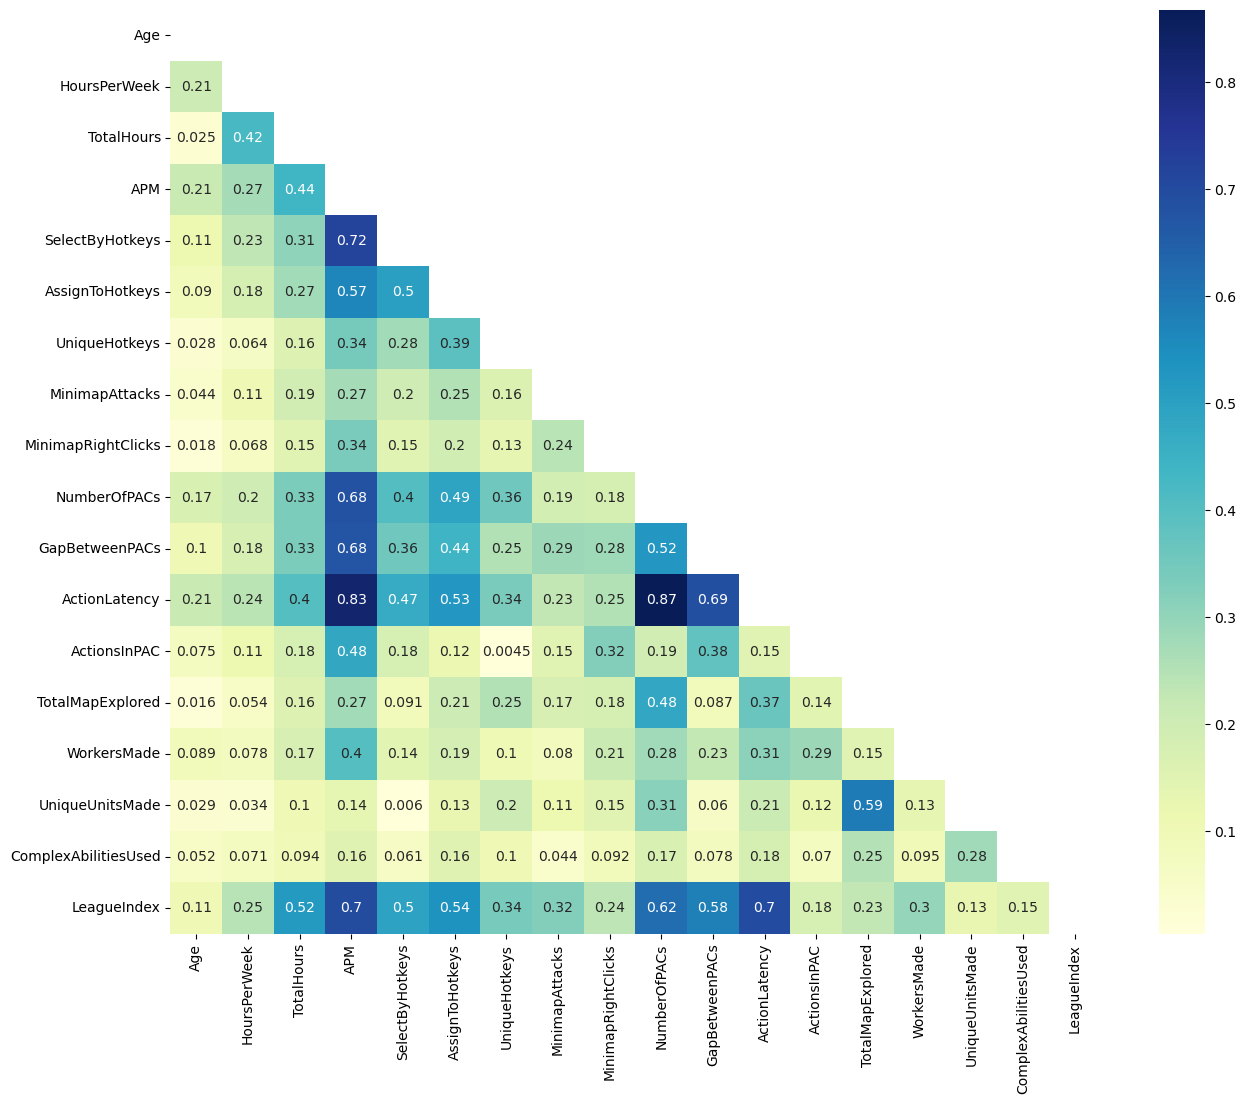

In [56]:
# Create a correlation matrix, calculate the coefficient in absolute values
corr_matrix = clean_df.corr().abs()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(15, 12))

# Generate a heatmap, the bigger the coefficient, the darker the color
sns.heatmap(corr_matrix, mask=mask, cmap='YlGnBu', annot=True, annot_kws={"ha": 'center', "va": 'center'}, ax=ax)

# Display the heatmap
plt.show()

The distribution of HoursPerWeek in each LeagueIndex is visualized using violin plots. However, due to excessive skewness, the `TotalHours` column will be removed from the analysis and modeling. Additionally, I will delete the 17th column (`ComplexUnitsMade`) with zero variation to reduce redundancy.

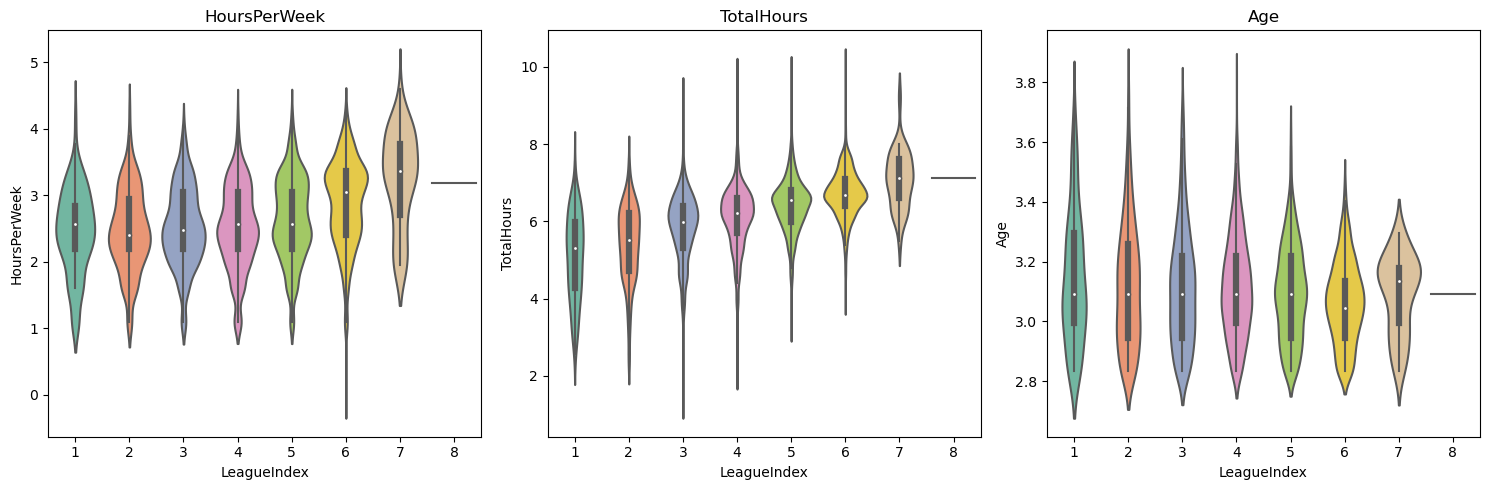

In [57]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Create violin plots for each column in the specified order
sns.violinplot(x='LeagueIndex', y='HoursPerWeek', data=clean_df, ax=axes[0], palette="Set2")
sns.violinplot(x='LeagueIndex', y='TotalHours', data=clean_df, ax=axes[1], palette="Set2")
sns.violinplot(x='LeagueIndex', y='Age', data=clean_df, ax=axes[2], palette="Set2")
# Set titles for each subplot

axes[0].set_title('HoursPerWeek')
axes[1].set_title('TotalHours')
axes[2].set_title('Age')

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

In [50]:
from sklearn.feature_selection import VarianceThreshold

# find if there are any features with zero variance
selector = VarianceThreshold()
x_var0 = selector.fit_transform(clean_df)
x_var0.shape
pd.DataFrame(x_var0).head()


new_df = clean_df.copy().drop(['LeagueIndex'], axis=1)
skewed_feats = new_df.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
display(skewness.head(10))

# redue the skewness of all the columns with skewness > 1.5 using Log-log transformation
skewness = skewness[abs(skewness) > 1.5]

skewed_features = skewness.index
for feat in skewed_features:
    new_df[feat] = np.log1p(new_df[feat]).astype(float)
# add the LeagueIndex back to the dataframe
new_df['LeagueIndex'] = clean_df['LeagueIndex']

# check the skewness again
skewed_feats = new_df.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
display(skewness.head(8))


Skew
TotalHours            13.883884
MinimapAttacks         4.665669
ComplexAbilitiesUsed   3.906119
SelectByHotkeys        2.934451
MinimapRightClicks     2.541558
ComplexUnitsMade       2.288427
GapBetweenPACs         1.898395
WorkersMade            1.661125
ActionsInPAC           1.598843
HoursPerWeek           1.554739

Skew
MinimapAttacks        4.660041
ComplexAbilitiesUsed  3.902256
SelectByHotkeys       2.899292
MinimapRightClicks    2.537629
ComplexUnitsMade      2.287964
WorkersMade           1.658169
AssignToHotkeys       1.148459
Age                   0.587267

### Splitting Dataset
The data is imbalanced and I want the test set to cover all the classes, so I chooes 75% of the data as train data and the rest as test data. In this project, target is `LeagueIndex` and the others are features.

In [51]:
clean_df = new_df.drop(['ComplexUnitsMade'], axis=1)

train_df, test_df = train_test_split(clean_df, test_size=0.25, random_state=42, stratify=clean_df['LeagueIndex'])
X_train, y_train = train_df.drop('LeagueIndex', axis=1), train_df['LeagueIndex']
X_test, y_test = test_df.drop('LeagueIndex', axis=1), test_df['LeagueIndex']

## Modeling
The final model I selected is Random Forest with class weights after comparision.

Process:
 
- Select candidate models based on the problem at hand
    - Based on my knowlwdge, I tried Logistic regression, random forest, supported vector machine and XGBoosting, run models on defualt settings on the same dataset and choose the one performs the best. Since XGBoosting can deal with missing data, I run the model on data that all the "?" are replaced by nan, but the result is not good.
    - Then I run `LazyPredict` uisng both Classifier (scored by f1-macro) and Regressor (scored by MSE) and tried on the top ranked models, which are GaussianNB, BaggingClassifier, LGBMRegressor, and GradientBoostingRegressor. For the results of regressors, I calculate the y_final by rounding the y_pred, if the decimal part is greater than 0.5, then round up, otherwise round down, and then pass the result to get the classifier report and confusion matrix.
- Train the model on part of the data (train data) 
- Adjust hyperparameters to optimize performance 
    - Added scalers to standardize data (RobustScaler).
    - Implemented Linear Discriminant Analysis (LDA) to reduce dimentionality and tuned on the number of components shrinkage and solver. (did not improve the model performance)
    - Used `GridSearch` to tune the hyperparameters of the chosen model.
    - Created weights for each class to deal with the imbalance data. (`smooth_class_weights`: calculates the class weights for each class based on the frequency of occurrences. The `mu` parameter is used to control the degree of smoothing)
- Evaluate model performance using a hidden part of the data
    - The metric I used to evaluate the models is the macro F1 score because it provides a balanced assessment of the model's performance across all classes, considering both precision and recall.
    - In our case, false positives and false negatives should be treated the same, and each class should be treated equally. Therefore, I chose the macro F1 score instead of F1 weighted or F1 micro.
    - I also use the ROC-AUC as a reference, since I want the model to learn from all the classes.

### Random Forest Classification

In [54]:
# use random forest to predict the league index using pipeline
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV

# the weights make the model perform better
smooth_weights = {4: 1, 5: 1, 6: 1, 3: 1.0241698124135936, 2: 1.4893541552233802, 1: 2.221722048936607, 7: 3.098792067657481, 8: 3.3364637195346}

pipeline = Pipeline([
    ('scaler', RobustScaler()),
    # ('lda', LinearDiscriminantAnalysis(n_components=4)),  # LDA for dimensionality reduction
    ('rf', RandomForestClassifier(random_state=42, n_estimators=300, max_depth=15, class_weight=smooth_weights, max_features='sqrt'))
])


param_grid = {
    # 'rf__class_weight': [smooth_class_weights(train_df, mu=mu) for mu in np.arange(0.15, 0.5, 0.05)],
    # 'rf__n_estimators': [250, 300, 350],
    # 'rf__max_depth': [10, 15],
    'rf__min_samples_split': [10, 15],
    # 'rf__max_features': ['sqrt', 'log2']
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', verbose=1, n_jobs=-1)

grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)
print(grid.score(X_test, y_test))

Fitting 5 folds for each of 28 candidates, totalling 140 fits
{'rf__class_weight': {4: 1, 5: 1, 6: 1, 3: 1.0241698124135936, 2: 1.4893541552233802, 1: 2.221722048936607, 7: 3.098792067657481, 8: 3.3364637195346}, 'rf__max_depth': 15, 'rf__min_samples_split': 10}
0.5132140708523604
0.5209211458158718


### Interpretation
The model's overall performance is moderate, with variations across different classes. Class 8 has a precision of 1.00 and a recall of 0.93, while class 7 exhibits a relatively high F1-score. This indicates that almost all instances predicted as class 7 and 8 were correct, respectively. This difference in performance may be attributed to significant distinctions between professional players (including Grandmasters) and others. Class 3 has the lowest precision of 0.34, suggesting that our model struggles to differentiate players in Gold and Platinum tiers. This could be due to the abundance of data from Platinum players, some of whom have recently achieved their new ranks, making it challenging to discern the subtle differences. 

The area under the ROC curve (AUC) value of 0.68 indicates that, on average, the classifier performs better than random guessing (12.5%) in distinguishing between positive and negative instances across all classes.

              precision    recall  f1-score   support

           1       0.41      0.45      0.43        42
           2       0.38      0.34      0.36        87
           3       0.34      0.25      0.29       138
           4       0.38      0.49      0.43       203
           5       0.44      0.44      0.44       200
           6       0.59      0.51      0.55       154
           7       0.71      0.88      0.79        17
           8       1.00      0.93      0.96        14

    accuracy                           0.44       855
   macro avg       0.53      0.54      0.53       855
weighted avg       0.45      0.44      0.44       855



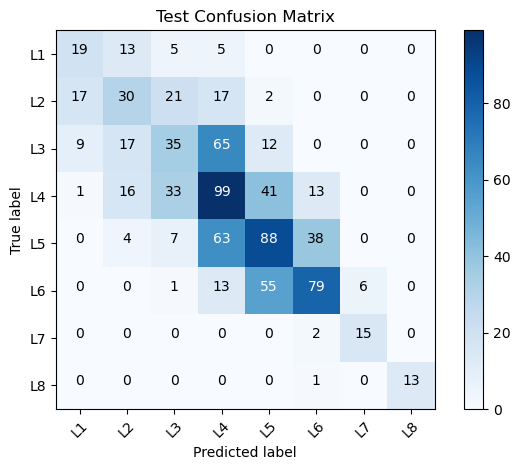

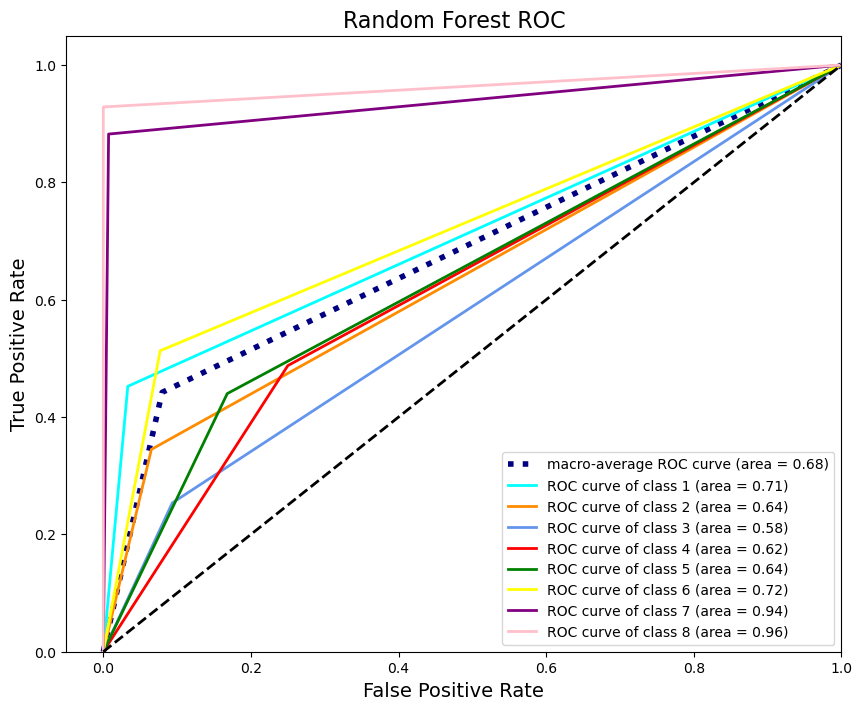

In [53]:
# report the classification report
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=1))

# report the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, title = 'Test')

# report the ROC curve
plot_roc(y_test, y_pred, 'Random Forest')

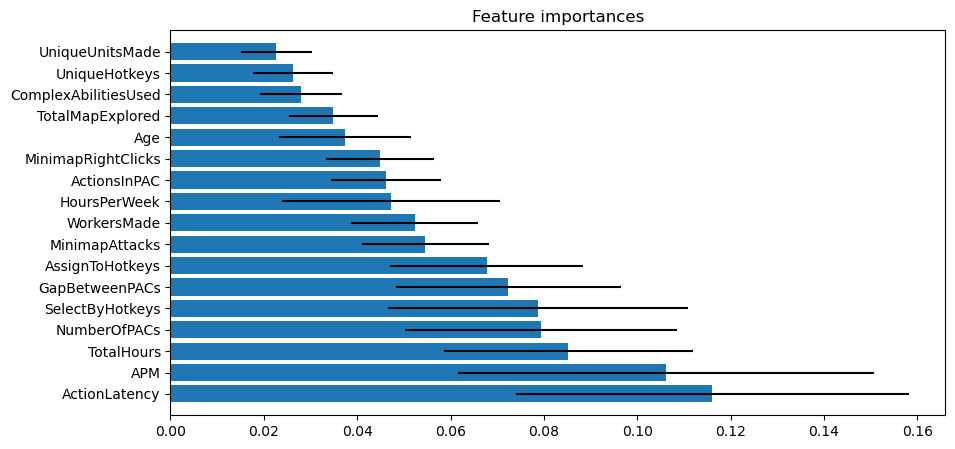

In [55]:
# plot feature importance
importances = grid.best_estimator_.named_steps['rf'].feature_importances_
std = np.std([tree.feature_importances_ for tree in grid.best_estimator_.named_steps['rf'].estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# plot the feature importances of the forest
plt.figure(figsize=(10, 5))
plt.title("Feature importances")
plt.barh(range(X_train.shape[1]), importances[indices], xerr=std[indices], align="center")
plt.yticks(range(X_train.shape[1]), X_train.columns[indices])
plt.ylim([-1, X_train.shape[1]])
plt.show()